In [1]:
# https://www.kaggle.com/neurol/keras-classifier
# https://www.kaggle.com/shawon10/captcha-recognition
# https://www.kaggle.com/dhruvaditya/captcha-recognition

# Objetivo

Criar um sistema capaz de decifrar imagend de Captcha

In [26]:
#Imports

from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import confusion_matrix


# 2 - Dataset
O dataset gerado é lido, sendo o nome do arquivo o texto contido na imagem

## 2.1 - Leitura

In [3]:
def read_dataset(symbols, captcha_dir = 'images/dataset'):
    
    num_symbols = len(symbols)
    n_samples = len(os.listdir(captcha_dir))
    #X = np.zeros((n_samples, 50, 200, 1))
    X = np.zeros((n_samples, 60, 160, 1))
    y = np.zeros((5, n_samples, num_symbols))

    for i, pic in enumerate(os.listdir(captcha_dir)):
        
        img = cv2.imread(os.path.join(captcha_dir, pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4] # retira o .png
        
        # Se nome do arquivo da imagem tem até 5 caracteres
        if len(pic_target) < 6:
            
            # Coloca o valor dos pixels entre 0 e 1
            img = img / 255.
            img = np.reshape(img, (60, 160, 1))
            # cada captcha possui 5 caracteres
            targs = np.zeros((5, num_symbols))
            
            # Seta a sequência de letras alvo
            # O Alvo será uma matriz de todos símbolos pelas 5 posições presentes no captcha.
            # Se aquela posição corresponde aquele símbolo o valor da célula será 1, e 0 caso contrário.
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
                
            X[i] = img
            y[:, i] = targs

    return X, y

In [4]:
symbols = string.ascii_lowercase + string.ascii_uppercase + "0123456789"
X, y = read_dataset(symbols)
#print (X, y)

## 2.2 - Exemplos

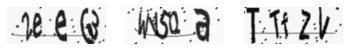

In [5]:

fig = plt.figure()
j = 1;
for i in (11, 32, 154):
    img = X[i,:,:]
    img.shape = (60,160)
    a=fig.add_subplot(1,3,j)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    j = j +1;
plt.show()

# 3 - Divisão dos Dados

In [6]:
# Das 1000 imagens 100 foram separadas para data set de teste.
X_train, y_train = X[:900], y[:, :900]
X_test, y_test = X[900:], y[:, 900:]


In [7]:
img_shape = (60, 160, 1)

In [11]:

def create_net(num_symbols):

    # Camada de entrada
    img = layers.Input(shape=img_shape) 
    
    # Segunda camada - convolução com relu, podemos experimentar com sigma
    conv1 = layers.Conv2D(16, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(img)    
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    
    # Terceira camada - convolução com relu, podemos experimentar com sigma
    conv2 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    
    # Quarta camada - convolução com relu, podemos experimentar com sigma
    conv3 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(mp2)
    bn = layers.BatchNormalization()(conv3)
    
    # Camada de saída
    mp3 = layers.MaxPooling2D(padding='same')(bn) 
    flat = layers.Flatten()(mp3)
    
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    model = Model(img, outs)
    model.compile('adam', loss=['categorical_crossentropy', 'categorical_crossentropy',
                                   'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
    model.summary()
    return model


In [33]:
def create_net(num_symbols):
    
    input_layer = layers.Input(shape=img_shape) 
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)

    out = [Dense(num_symbols, name='digit%d' % i, activation='softmax')(x) for i in range(5)]
    model = Model(inputs=input_layer, outputs=out)

    # initiate Adam optimizer
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    model.summary()    
    
    return model

In [34]:
#https://github.com/zaraanry/CAPTCHA-Solver
net = create_net(len(symbols))
#history = net.fit(X_train, np.array([y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]]), epochs=50, validation_split=0.2)
history = net.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], epochs=50, validation_split=0.2)



# Acertos e erros de teste:



Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 60, 160, 32)  832         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 30, 80, 32)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 30, 80, 48)   38448       max_pooling2d_15[0][0]           
____________________________________________________________________________________________

23/23 [==============================] - 11s 492ms/step - loss: 0.4107 - digit0_loss: 0.0820 - digit1_loss: 0.0822 - digit2_loss: 0.0823 - digit3_loss: 0.0819 - digit4_loss: 0.0822 - digit0_accuracy: 0.0181 - digit1_accuracy: 0.0222 - digit2_accuracy: 0.0153 - digit3_accuracy: 0.0236 - digit4_accuracy: 0.0208 - val_loss: 0.4149 - val_digit0_loss: 0.0828 - val_digit1_loss: 0.0828 - val_digit2_loss: 0.0830 - val_digit3_loss: 0.0832 - val_digit4_loss: 0.0831 - val_digit0_accuracy: 0.0333 - val_digit1_accuracy: 0.0167 - val_digit2_accuracy: 0.0111 - val_digit3_accuracy: 0.0222 - val_digit4_accuracy: 0.0000e+00
Epoch 9/50
23/23 [==============================] - 11s 483ms/step - loss: 0.4107 - digit0_loss: 0.0821 - digit1_loss: 0.0822 - digit2_loss: 0.0823 - digit3_loss: 0.0819 - digit4_loss: 0.0822 - digit0_accuracy: 0.0250 - digit1_accuracy: 0.0222 - digit2_accuracy: 0.0222 - digit3_accuracy: 0.0236 - digit4_accuracy: 0.0181 - val_loss: 0.4154 - val_digit0_loss: 0.0829 - val_digit1_loss: 

23/23 [==============================] - 11s 470ms/step - loss: 0.4081 - digit0_loss: 0.0815 - digit1_loss: 0.0818 - digit2_loss: 0.0819 - digit3_loss: 0.0813 - digit4_loss: 0.0817 - digit0_accuracy: 0.0389 - digit1_accuracy: 0.0319 - digit2_accuracy: 0.0167 - digit3_accuracy: 0.0403 - digit4_accuracy: 0.0333 - val_loss: 0.4149 - val_digit0_loss: 0.0828 - val_digit1_loss: 0.0827 - val_digit2_loss: 0.0829 - val_digit3_loss: 0.0834 - val_digit4_loss: 0.0831 - val_digit0_accuracy: 0.0278 - val_digit1_accuracy: 0.0167 - val_digit2_accuracy: 0.0278 - val_digit3_accuracy: 0.0167 - val_digit4_accuracy: 0.0056
Epoch 22/50
23/23 [==============================] - 11s 495ms/step - loss: 0.4076 - digit0_loss: 0.0814 - digit1_loss: 0.0817 - digit2_loss: 0.0818 - digit3_loss: 0.0811 - digit4_loss: 0.0816 - digit0_accuracy: 0.0319 - digit1_accuracy: 0.0403 - digit2_accuracy: 0.0236 - digit3_accuracy: 0.0444 - digit4_accuracy: 0.0319 - val_loss: 0.4155 - val_digit0_loss: 0.0830 - val_digit1_loss: 0.0

23/23 [==============================] - 11s 487ms/step - loss: 0.3673 - digit0_loss: 0.0725 - digit1_loss: 0.0735 - digit2_loss: 0.0742 - digit3_loss: 0.0733 - digit4_loss: 0.0738 - digit0_accuracy: 0.1403 - digit1_accuracy: 0.1333 - digit2_accuracy: 0.1278 - digit3_accuracy: 0.1556 - digit4_accuracy: 0.1444 - val_loss: 0.4290 - val_digit0_loss: 0.0848 - val_digit1_loss: 0.0857 - val_digit2_loss: 0.0856 - val_digit3_loss: 0.0872 - val_digit4_loss: 0.0857 - val_digit0_accuracy: 0.0222 - val_digit1_accuracy: 0.0167 - val_digit2_accuracy: 0.0000e+00 - val_digit3_accuracy: 0.0389 - val_digit4_accuracy: 0.0278
Epoch 35/50
23/23 [==============================] - 11s 472ms/step - loss: 0.3558 - digit0_loss: 0.0701 - digit1_loss: 0.0713 - digit2_loss: 0.0722 - digit3_loss: 0.0711 - digit4_loss: 0.0710 - digit0_accuracy: 0.1597 - digit1_accuracy: 0.1556 - digit2_accuracy: 0.1347 - digit3_accuracy: 0.1750 - digit4_accuracy: 0.1611 - val_loss: 0.4333 - val_digit0_loss: 0.0854 - val_digit1_loss:

23/23 [==============================] - 11s 471ms/step - loss: 0.1946 - digit0_loss: 0.0359 - digit1_loss: 0.0425 - digit2_loss: 0.0406 - digit3_loss: 0.0376 - digit4_loss: 0.0381 - digit0_accuracy: 0.5931 - digit1_accuracy: 0.5083 - digit2_accuracy: 0.5333 - digit3_accuracy: 0.5653 - digit4_accuracy: 0.5556 - val_loss: 0.4971 - val_digit0_loss: 0.0940 - val_digit1_loss: 0.1026 - val_digit2_loss: 0.1025 - val_digit3_loss: 0.1015 - val_digit4_loss: 0.0966 - val_digit0_accuracy: 0.0333 - val_digit1_accuracy: 0.0111 - val_digit2_accuracy: 0.0111 - val_digit3_accuracy: 0.0333 - val_digit4_accuracy: 0.0444
Epoch 48/50
23/23 [==============================] - 11s 470ms/step - loss: 0.1819 - digit0_loss: 0.0338 - digit1_loss: 0.0365 - digit2_loss: 0.0393 - digit3_loss: 0.0357 - digit4_loss: 0.0367 - digit0_accuracy: 0.5931 - digit1_accuracy: 0.5875 - digit2_accuracy: 0.5083 - digit3_accuracy: 0.5875 - digit4_accuracy: 0.5500 - val_loss: 0.5013 - val_digit0_loss: 0.0952 - val_digit1_loss: 0.1

In [9]:
def create_net(num_symbols):
    # Define the model
    model3 = Sequential()
    model3.add(Conv2D(3, 3, strides=(3, 3), padding='valid', input_shape=(img_shape), activation="relu", use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros', name='FirstConv'))
    model3.add(Conv2D(3, 3, strides=(3, 3),  padding='valid', activation="relu", use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros', name='SecondConv'))
    model3.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling2'))
    model3.add(Flatten(name='Flatten'))
    #model3.add(Dense(128, name='Dense128', activation="relu"))
    #model3.add(Dense(num_classes, name='DenseOutput', activation="softmax"))
    
    outs = []
    i = 1;
    for _ in range(5):
        model3.add(Dense(128, name='Dense128_'+str(i), activation="relu"))
        #dens1 = layers.Dense(64, activation='relu')(flat)
        #drop = layers.Dropout(0.5)(dens1)
        model3.add(Dense(num_symbols, name='DenseOutput_'+str(i), activation="relu"))
        #res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        #outs.append(res)
        i = i + 1;
    
    #model = Model(img, outs)
    

    # Compile the model
    model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model3;

In [35]:
def predict(img, n_symbols):
    
    #img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) / 255.
    res = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, n_symbols))
    l_ind = []
    probs = []
    
    for a in ans:
        l_ind.append(np.argmax(a))
        probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt, sum(probs) / 5

--- Amostra #1 ---


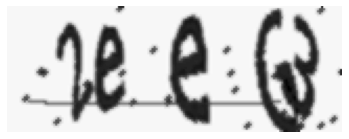

Predict: 2eeG3


--- Amostra #1 ---


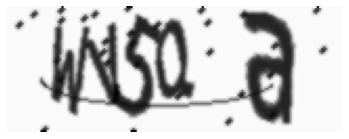

Predict: Wv5Qa


--- Amostra #1 ---


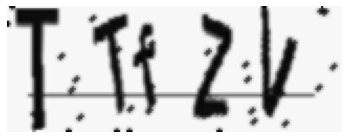

Predict: TTfcV


4/4 [==============================] - 0s 16ms/step - loss: 51.3707 - dense_1_loss: 9.4635 - dense_3_loss: 9.9848 - dense_5_loss: 10.0321 - dense_7_loss: 11.6968 - dense_9_loss: 10.1934 - dense_1_accuracy: 0.0400 - dense_3_accuracy: 0.0800 - dense_5_accuracy: 0.0400 - dense_7_accuracy: 0.0400 - dense_9_accuracy: 0.0300


[51.370704650878906,
 9.463460922241211,
 9.984829902648926,
 10.032137870788574,
 11.696846961975098,
 10.193425178527832,
 0.03999999910593033,
 0.07999999821186066,
 0.03999999910593033,
 0.03999999910593033,
 0.029999999329447746]

In [15]:
j = 1
for i in (11, 32, 154):
    print("--- Amostra #" + str(j) + " ---")    
    fig = plt.figure()
    img = X[i,:,:]
    img.shape = (60,160)    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    capt, prop = predict(img, len(symbols))
    print("Predict: " + capt)
    print("\n")
    
net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


--- Amostra #1 ---


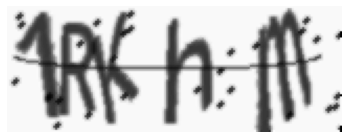

Predict: EEhVd


--- Amostra #1 ---


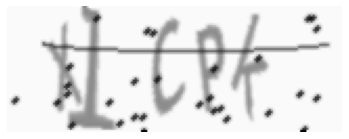

Predict: KhwwZ


--- Amostra #1 ---


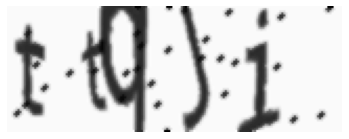

Predict: CUcs7


4/4 [==============================] - 0s 53ms/step - loss: 0.5208 - digit0_loss: 0.1052 - digit1_loss: 0.1074 - digit2_loss: 0.1066 - digit3_loss: 0.1045 - digit4_loss: 0.0972 - digit0_accuracy: 0.0300 - digit1_accuracy: 0.0400 - digit2_accuracy: 0.0100 - digit3_accuracy: 0.0400 - digit4_accuracy: 0.0500 


[0.5208129286766052,
 0.10515093058347702,
 0.10739587992429733,
 0.1066008061170578,
 0.1044684574007988,
 0.09719689190387726,
 0.029999999329447746,
 0.03999999910593033,
 0.009999999776482582,
 0.03999999910593033,
 0.05000000074505806]

In [36]:
j = 1
for i in (11, 32, 54):
    print("--- Amostra #" + str(j) + " ---")    
    fig = plt.figure()
    img = X_test[i,:,:]
    img.shape = (60,160)    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    capt, prop = predict(img, len(symbols))
    print("Predict: " + capt)
    print("\n")
    
net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


In [37]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

<ipython-input-37-c6ab7055161c>:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


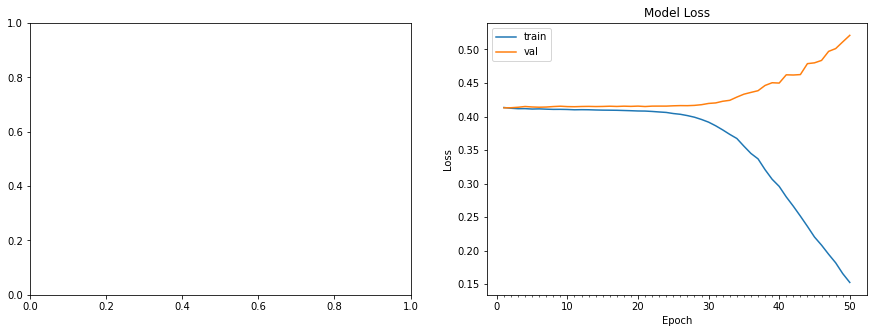

In [38]:
plot_model_history(history)

In [19]:
def accuracy(test_x, test_y, model):
    result = net.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class)
    #len(result) * 
    print(num_correct)
    num_caracteres = result[0].shape[0]
    accuracy = float(num_correct)/num_caracteres
    return (accuracy * 100)

In [20]:
#X_test = data_valid
#y_test = data_valid_target
net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], net))

4/4 [==============================] - 0s 16ms/step - loss: 51.3707 - dense_1_loss: 9.4635 - dense_3_loss: 9.9848 - dense_5_loss: 10.0321 - dense_7_loss: 11.6968 - dense_9_loss: 10.1934 - dense_1_accuracy: 0.0400 - dense_3_accuracy: 0.0800 - dense_5_accuracy: 0.0400 - dense_7_accuracy: 0.0400 - dense_9_accuracy: 0.0300
9
Accuracy on test data is: 9.00
